In [1]:
!pip install --upgrade keras_applications==1.0.6 keras==2.2.4

    100% |████████████████████████████████| 51kB 75.1MB/s ta 0:00:01
    100% |████████████████████████████████| 317kB 101.3MB/s ta 0:00:01
    100% |████████████████████████████████| 2.8MB 61.3MB/s ta 0:00:011████▎             | 1.6MB 82.7MB/s eta 0:00:01
    100% |████████████████████████████████| 17.3MB 96.1MB/s eta 0:00:01256kB 79.7MB/s eta 0:00:01            | 5.1MB 95.0MB/s eta 0:00:0100:01��█████     | 14.7MB 96.8MB/s eta 0:00:01
    100% |████████████████████████████████| 276kB 58.3MB/s ta 0:00:01
    100% |████████████████████████████████| 51kB 76.9MB/s ta 0:00:01
    100% |████████████████████████████████| 25.2MB 87.8MB/s ta 0:00:011 | 2.9MB 70.6MB/s eta 0:00:01�██▏                     | 8.0MB 86.3MB/s eta 0:00:01B/s eta 0:00:01��██████▊           | 16.3MB 97.5MB/s eta 0:00:01███████████████████████▊       | 19.5MB 78.8MB/s eta 0:00:01��██████████████▊    | 21.8MB 88.2MB/s eta 0:00:01
Requirement already up-to-date: six>=1.9.0 in /home/jovyan/modelarts-sdk (from keras==2.2.4)

In [1]:
import os, cv2, random
import numpy as np

# 画图工具
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.layers import Input, Dense
from keras.optimizers import RMSprop
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import Callback, EarlyStopping, TensorBoard
from keras.applications.xception import Xception
from keras import optimizers
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation,BatchNormalization,GlobalAveragePooling2D
from keras import backend as K
K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
from modelarts.session import Session
session = Session()

if not os.path.exists('./data'):
    session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

    # 使用tar命令解压资源包
    !tar xf ./image_recognition.tar.gz

    # 清理压缩包
    !rm -f ./image_recognition.tar.gz

In [3]:
DATA_DIR = './data/'  # 数据集路径
OUTPUT = './output/' # 模型保存位置
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)
if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)
    
# 下载数据集
from modelarts.session import Session
session = Session()

session.download_data(
    bucket_path="modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz",
    path="./image_recognition.tar.gz")

# 使用tar命令解压资源包
!tar xf ./image_recognition.tar.gz

# 清理压缩包
!rm -f ./image_recognition.tar.gz



ROWS = 299
COLS = 299
CHANNELS = 3

Successfully download file modelarts-labs/notebook/DL_image_recognition/image_recognition.tar.gz from OBS to local ./image_recognition.tar.gz
tar: data: Cannot utime: Operation not permitted
tar: data: Cannot change mode to rwsr-s---: Operation not permitted
tar: Exiting with failure status due to previous errors


In [4]:
image_file_names = [DATA_DIR+i for i in os.listdir(DATA_DIR)] 
dogs = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'dog' in i]
cats = [DATA_DIR+i for i in os.listdir(DATA_DIR) if 'cat' in i]

# 数据洗牌
random.shuffle(image_file_names)

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) # 彩色模式读取图像
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_data(image_file_names):
    count = len(image_file_names)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)
    
    for i, image_file in enumerate(image_file_names):
        image = read_image(image_file)
        data[i] = image
        if i%1000 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

# 读取图片至内存
images = prep_data(image_file_names)

Processed 0 of 25000
Processed 1000 of 25000
Processed 2000 of 25000
Processed 3000 of 25000
Processed 4000 of 25000
Processed 5000 of 25000
Processed 6000 of 25000
Processed 7000 of 25000
Processed 8000 of 25000
Processed 9000 of 25000
Processed 10000 of 25000
Processed 11000 of 25000
Processed 12000 of 25000
Processed 13000 of 25000
Processed 14000 of 25000
Processed 15000 of 25000
Processed 16000 of 25000
Processed 17000 of 25000
Processed 18000 of 25000
Processed 19000 of 25000
Processed 20000 of 25000
Processed 21000 of 25000
Processed 22000 of 25000
Processed 23000 of 25000
Processed 24000 of 25000


In [5]:
num_train_samples = len(image_file_names)
num_classes = 2
labels = []

index = 0
for i in image_file_names:
    if 'dog.' in i:
        labels.append(1)
    else:
        labels.append(0)
# 把类别标签转换为onehot编码
labels = np_utils.to_categorical(labels, num_classes)

In [6]:
train_data, test_data, train_label, test_label = train_test_split(images, labels, test_size=0.25, random_state=10)
train_data, validate_data, train_label, validate_label = train_test_split(train_data, train_label, test_size=0.25, random_state=10)

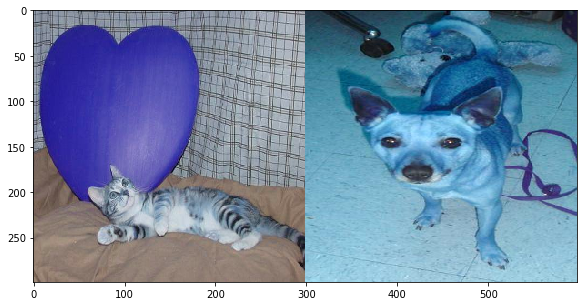

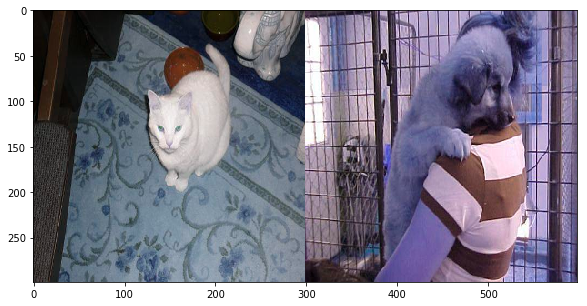

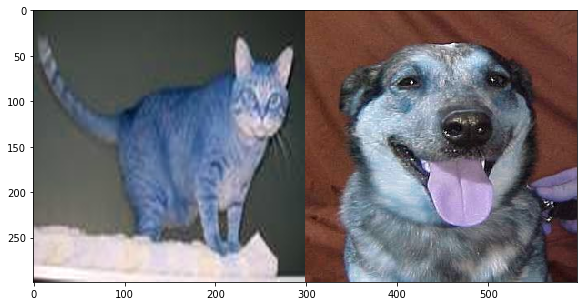

In [7]:
def show_cats_and_dogs(idx):
    cat = read_image(cats[idx])
    dog = read_image(dogs[idx])
    pair = np.concatenate((cat, dog), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
    
for idx in range(0,3):
    show_cats_and_dogs(idx)

In [8]:
batch_size = 18 # 批大小
learning_rate = 1e-4 # 设置学习率为1e-4

In [9]:
optimizer = RMSprop(lr=learning_rate) # 优化器使用 RMSprop

In [10]:
# Loss记录
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
def run_catdog():
    history = LossHistory()
    # 开始训练
    history=model.fit(train_data, train_label,
              epochs=epochs, batch_size=batch_size,
              verbose=2,shuffle=True,validation_data=(validate_data,validate_label),callbacks=[history, early_stopping])
    return history

In [11]:
base_model = Xception(weights="imagenet", include_top=False, pooling=None, input_shape=(ROWS, COLS, CHANNELS), classes=2)

x = base_model.output
#添加自己的全链接分类层
x = Flatten()(x)

x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)
#训练模型
model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

83689472/83683744 [==============================] - 211s 3us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________

In [14]:
epochs=30
optimizer = optimizers.RMSprop(lr=1e-4)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')

history = run_catdog()
# 训练好的模型可以保存起来，永久使用

model.save(os.path.join(OUTPUT, 'model.h5'))

Train on 14062 samples, validate on 4688 samples
Epoch 1/30
 - 438s - loss: 0.2528 - acc: 0.9718 - val_loss: 0.0476 - val_acc: 0.9923
Epoch 2/30
 - 424s - loss: 0.0345 - acc: 0.9925 - val_loss: 0.0907 - val_acc: 0.9863
Epoch 3/30
 - 423s - loss: 0.0234 - acc: 0.9962 - val_loss: 0.0965 - val_acc: 0.9891
 - 424s - loss: 0.0204 - acc: 0.9974 - val_loss: 0.0815 - val_acc: 0.9917


In [16]:
# 预测测试集
predictions = model.predict(test_data, verbose=0)
# 评估模型准确度
predictions_test = []
test_label_test = []
for p in predictions:

    if int(round(p[0])) == 1:
        predictions_test.append(1)
    else:
        predictions_test.append(0)
for t in test_label:
    if int(t[0]) == 1:
        test_label_test.append(1)
    else:
        test_label_test.append(0)
acc = accuracy_score(test_label_test, predictions_test)

print('训练得到的猫狗识别模型的准确度是：%f' % acc)

训练得到的猫狗识别模型的准确度是：0.992160
